Import libraries and set global parameters

In [188]:
# %pip install tableone

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, mean_squared_error
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor

from tableone import TableOne

random_seed = 42 # do not change

Import data

In [190]:
data = pd.read_csv('hw2_data.csv')
# data.head()

In [191]:
# Split the data into features (X), treatment (T) and target (y)
confounders = [f'X{i}' for i in range(30)]
X = data[confounders]
T = data['T']
y = data['Y']


In [192]:
# Split the data into training and validation sets / Do not change
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=random_seed)

In [193]:
def train_propensity_model(model, X_train, T_train):
    """
    Return a fitted propensity model on your training data
    :param model:
    :param X_train:
    :param T_train:
    :return:
    """
    return model.fit(X_train, T_train)

def eval_propensity_model(fitted_model, X_val, T_val, model_name):
    """
    Check your fitted propensity model using the brier score and calibration curve.

    You must print or return (and then print for us to see) the brier score.
    You must show the calibration curve.
    :param fitted_model:
    :param X_val:
    :param T_val:
    :return:
    """
    T_prob_val = fitted_model.predict_proba(X_val)[:,1] # Probabilities for the positive class
    brier_score = brier_score_loss(T_val, T_prob_val)
    print(f'Brier Score: {brier_score}')

    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(T_val, T_prob_val, n_bins=10)

    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label = model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()
    return brier_score

## Train and Evaluate at least two models

Brier Score: 0.16364160455032925


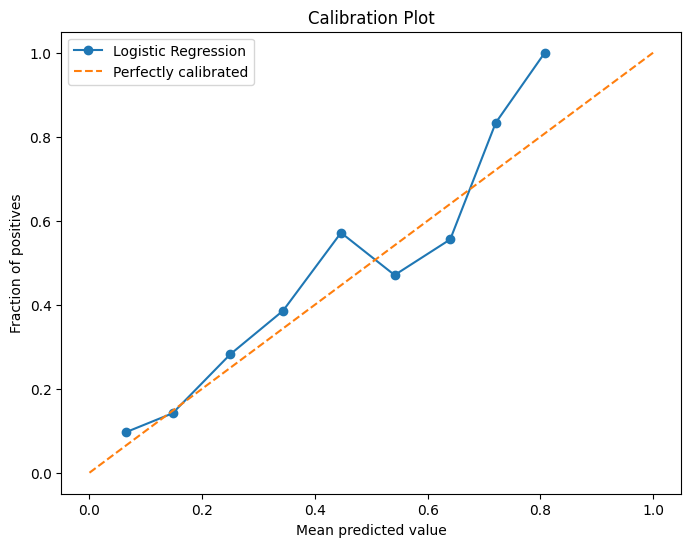

Brier Score: 0.17893956834532376


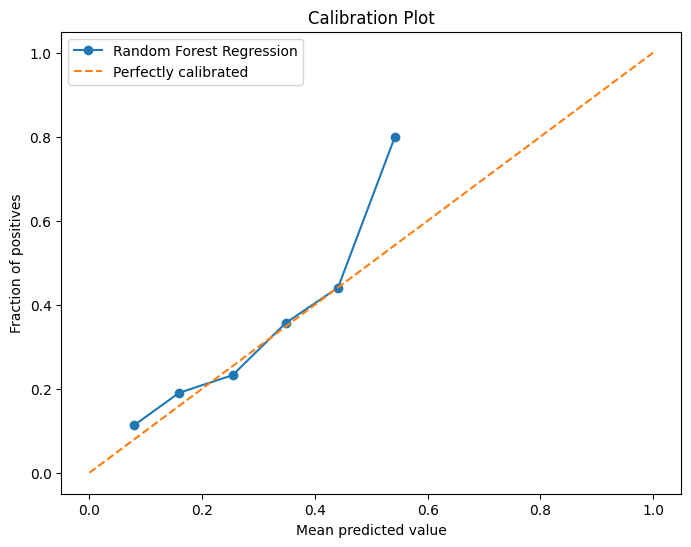

In [194]:
log_model = LogisticRegression(max_iter=1000)
fitted_log_model = train_propensity_model(log_model, X_train, T_train)
log_brier = eval_propensity_model(fitted_log_model, X_val, T_val, "Logistic Regression")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
fitted_rf_model = train_propensity_model(rf_model, X_train, T_train)
rf_brier = eval_propensity_model(fitted_rf_model, X_val, T_val, "Random Forest Regression")

Q1. Explain what the Brier score represents? What is the best possible Brier score? What is the Brier score if the model always guesses 0.5?\
Q2. Explain what the calibration plot shows? What is the best possible calibration plot?  
Q3. The sklearn implementation of calibration_plot (see Tutorial) has a parameter "n_bins". Explain this parameter. What happens if you use too many bins (for example 100 on this dataset) or too little bins (for example 1)?
#### Q4. Choose a propensity model and explain why you chose that model?


#### Check if the "overlap" assumption is reasonable on this data, given the propensity model that you have selected:

In [195]:
def check_overlap(propensity_model, X_train, T_train):
    """
    Show histograms of the propensity on the T=0 and the T=1 group like in the tutorial
    Use this to ascertain if there is a violation of overlap.

    You must show the graph.
    :param propensity_model:
    :param X_train:
    :param T_train:
    :return:
    """
    T_prob_train = propensity_model.predict_proba(X_train)[:,1]
    # Separate the probabilities for treatment = 0 and treatment = 1
    prob_treatment_0 = T_prob_train[T_train == 0]
    prob_treatment_1 = T_prob_train[T_train == 1]

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(prob_treatment_0, bins=20, alpha=0.6, label='Treatment = 0', color='blue')
    plt.hist(prob_treatment_1, bins=20, alpha=0.6, label='Treatment = 1', color='red')

    # Add labels and title
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Histograms of Predicted Probabilities for Treatment = 0 and Treatment = 1')
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

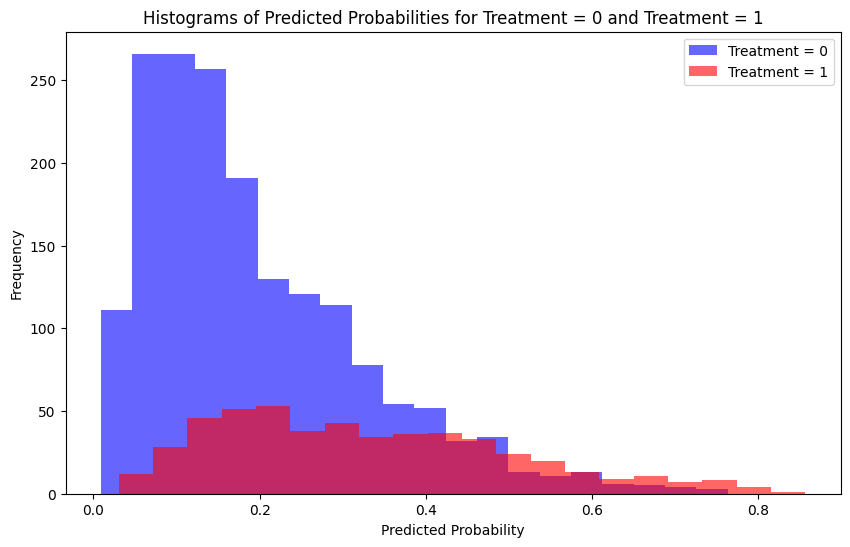

In [196]:
check_overlap(fitted_log_model, X_train, T_train)

#### Q5. Explain why there is or is not overlap in this sample?
For this exercise do not trim the data, even if you deemed it necessary.

## S-Learners

In [197]:
def train_s_learner(model, X_train, y_train):
    """
    Return a fitted s-learner model on your training data
    :param model:
    :param X_train:
    :param y_train:
    :return:
    """
    return model.fit(X_train, y_train)

def s_learner_model_selection(models, metric, X_train, y_train, X_val, y_val):
    """
    Use the validation set to select the model with the best performance over the provided metric (e.g. rmse)
    Note that X_train and X_val must include the treatment column for the s-learner.

    You may select models in a more complicated way (like you would in real life). But here you can simplify.
    You must either return the fitted model or show the scores that lead to your decision.
    :param model:
    :param metric:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :return:
    """
    best_score = float('inf')
    best_model = None
    for model_name, model in models.items():
        fitted_model = model.fit(X_train, y_train)
        preds = fitted_model.predict(X_val)
        score = metric(y_val, preds)
        print(f"{model_name}: {metric.__name__}: {score:.4f}")
        if score < best_score:
            best_score = score
            best_model = fitted_model
    return best_model


In [198]:
models = []
X_train_s = pd.concat([X_train, T_train], axis=1)
X_val_s = pd.concat([X_val, T_val], axis=1)
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

fitted_s_learner = s_learner_model_selection(
    models=models,
    metric=mean_squared_error,
    X_train=X_train_s,
    y_train=y_train,
    X_val=X_val_s,
    y_val=y_val)

Linear Regression: mean_squared_error: 12.4834
Random Forest: mean_squared_error: 23.2316
XGBoost: mean_squared_error: 16.6706


In [199]:
def prepare_data_for_s_learner_inference(X):
    """
    Receives X, data, and returns two sets of data. One with T=1 and the other with T=0.
    For example, if the X = [x1, x_2] then this function returns X1 = [x1, x2, 1] and X0 = [x1, x2, 0]

    You must return two datasets, one for T=1 and one for T=0.
    :param X:
    :return:
    """
    X1 = X.copy()
    X1['T'] = 1
    X0 = X.copy()
    X0['T'] = 0
    return X1, X0

def calculate_s_learner_ate(s_learner_model, X):
    """
    Receives an s learner model and data

    You must return or print the ate estimation on X based on the S-Learner.
    :param s_learner:
    :param X:
    :return:
    """
    X1, X0 = prepare_data_for_s_learner_inference(X)
    pred1 = s_learner_model.predict(X1)
    pred0 = s_learner_model.predict(X0)
    ate = np.mean(pred1 - pred0)
    return ate

Provide the point-estimation of the ate on the validation set

In [200]:
calculate_s_learner_ate(fitted_s_learner, X_val)

np.float64(1.2974360113920513)

In [201]:
# for name, model in models.items():
#     print(f"\n--- {name} ---")
#     fitted_model = train_s_learner(model, X_train_s, y_train)
#     ate = calculate_s_learner_ate(fitted_model, X_val)
#     print(f"Estimated ATE: {ate:.4f}")

Q6. Using a Lasso model, check the ATE over different regularization parameters (see below) \
What happens to the ATE with the S-Learner? Why?

In [202]:
from sklearn.linear_model import Lasso
alphas = [0.05, 0.1,0.2,0.3,0.4]
# models = {}
for alpha in alphas:
    # models[f"Lasso_{alpha}"] = Lasso(alpha=alpha)
    print(calculate_s_learner_ate(train_s_learner(Lasso(alpha=alpha), pd.concat([X_train, T_train], axis=1), y_train), X_val))

1.1050785365914721
0.9104535300703168
0.5201469499316964
0.12983904746814548
0.0


Add 95% confidence intervals around the point estimation. You have freedom to choose how to do this. For example, bootstraps, parametric methods (e.g. linear regression coefficient), etc.

In [203]:
def s_learner_confidence_intervals(s_learner_model, X_train, y_train, X_val, y_val, n_bootstraps = 100):
    """
    Receives an s-learner model and returns 95% confidence intervals.
    You do not need to use every parameter passed to this method and you can add additional parameters.

    You must either print, visualize the confidence intervals or return them as a list.
    :param s_learner_model:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :return:
    """
    ates = []
    for _ in range(n_bootstraps):
        X_sample, y_sample = resample(X_train, y_train)
        model = s_learner_model.fit(X_sample, y_sample)
        ate = calculate_s_learner_ate(s_learner_model, X_val.drop(columns='T', errors='ignore'))
        ates.append(ate)
    lower = np.percentile(ates, 100 * alpha / 2)
    upper = np.percentile(ates, 100 * (1 - alpha / 2))
    return (lower, upper)

In [204]:
# for name, model in models.items():
#     print(f"\n{name} CI:")
#     fitted_model = train_s_learner(model, X_train_s, y_train)
#     ci = s_learner_confidence_intervals(fitted_model, X_train_s, y_train, X_val_s, y_val)
#     print(f"95% CI: {ci}")

In [205]:
s_ci = s_learner_confidence_intervals(Lasso(alpha=0.05), X_train_s, y_train, X_val_s, y_val)
print(s_ci) # if you did not show above

(np.float64(0.9201711344177718), np.float64(1.3795818351823925))


-----------------

## T-Learner

Select models for the t-learner. \
You will need a model for both intervention arms (T=1, T=0). \
Depending on your results, you may find that different models are better for different intervention arms. (For example, a linear model on T=0 and a tree-based model on T=1).


In [206]:
def train_t_learner(model, X_train, y_train):
    """
    Return a fitted s-learner model on your training data
    :param model:
    :param X_train:
    :param y_train:
    :return:
    """
    return model.fit(X_train, y_train)

def t_learner_model_selection(models, metric, X_train, y_train, X_val, y_val):
    """
    Use the validation set to select the model with the best performance over the provided metric (e.g. rmse)
    Note that X_train and y_train should only include the appropriate intervention arm's data.

    You may select models in a more complicated way (like you would in real life). But here you can simplify.
    You must either return the fitted model or show the scores that lead to your decision.
    :param models:
    :param metric:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :return:
    """
    best_score = float('inf')
    best_model = None
    for model_name, model in models.items():
        fitted_model = train_t_learner(model, X_train, y_train)
        preds = fitted_model.predict(X_val)
        score = metric(y_val, preds)
        print(f"{model_name}: {score:.4f}")
        if score < best_score:
            best_score = score
            best_model = fitted_model
    return best_model

In [ ]:
X_train_t1 = X_train.loc[T_train == 1]
X_train_t0 = X_train.loc[T_train == 0]
X_val_t1 = X_val.loc[T_val == 1]
X_val_t0 = X_val.loc[T_val == 0]
y_train_t1 = y_train.loc[T_train == 1]
y_train_t0 = y_train.loc[T_train == 0]
y_val_t1 = y_val.loc[T_val == 1]
y_val_t0 = y_val.loc[T_val == 0]



models_t0 = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}
models_t1 = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

In [209]:
from sklearn.metrics import mean_squared_error
import numpy as np

fitted_t_learner_1 = t_learner_model_selection(models_t0, mean_squared_error, X_train_t1, y_train_t1, X_val_t1, y_val_t1)
fitted_t_learner_0 = t_learner_model_selection(models_t1, mean_squared_error, X_train_t0, y_train_t0, X_val_t0, y_val_t0)
print(f"best model for t=1: {fitted_t_learner_1}")
print(f"best model for t=0: {fitted_t_learner_0}")



Linear Regression: 0.0001
Random Forest: 49.7399
XGBoost: 44.2323
Linear Regression: 0.0001
Random Forest: 9.7242
XGBoost: 5.7651
best model for t=1: LinearRegression()
best model for t=0: LinearRegression()


In [ ]:
from sklearn.metrics import r2_score

# Evaluate the fitted T-learner models using another metric - R2 score
y0_pred = fitted_t_learner_0.predict(X_val_t0)
y1_pred = fitted_t_learner_1.predict(X_val_t1)
r2_t0 = r2_score(y_val_t0, y0_pred)
print(f"R2 for t0_model (T=0): {r2_t0:.4f}")

r2_t1 = r2_score(y_val_t1, y1_pred)
print(f"R2 for t1_model (T=1): {r2_t1:.4f}")

R2 for t0_model (T=0): 1.0000
R2 for t1_model (T=1): 1.0000


In [210]:
def calculate_t_learner_ate(t_learner_model1, t_learner_model0, X):
    """
    Receive t-learners and data, return the ATE inferred over X

    You must return or print the ate estimation on X based on the T-Learner.
    :param t_learner_model:
    :param X1:
    :param X0:
    :return:
    """
    y1_pred = t_learner_model1.predict(X)
    y0_pred = t_learner_model0.predict(X)
    ate = np.mean(y1_pred - y0_pred)
    return ate
    

Provide the point-estimation of the ate on the entire validation set

In [211]:
calculate_t_learner_ate(fitted_t_learner_1, fitted_t_learner_0, X_val)

np.float64(1.957324915830741)

Q7. Using a Lasso model, check the ATE over different regularization parameters, alpha=1,2,3,4,5. \
Is this similar or different to what we saw earlier with the S-Learner as we increased regularization? If it was different, explain what causes this.

In [212]:
from sklearn.linear_model import Lasso
alphas = [0.05, 0.1, 0.2, 0.3, 0.4]
for alpha in alphas:
    t1_model = train_t_learner(Lasso(alpha=alpha), X_train.loc[T_train==1], y_train.loc[T_train==1])
    t0_model = train_t_learner(Lasso(alpha=alpha), X_train.loc[T_train==0], y_train.loc[T_train==0])
    print(calculate_t_learner_ate(t1_model, t0_model, X_val))

2.1020963670061
2.2421001004924213
2.5172664173760646
2.786891323615828
3.0405467026065356


## Answer 7:
With the T-learner, increasing the Lasso regularization parameter (alpha) actually increases the ATE, which is the opposite of what we saw with the S-learner, where higher alpha reduced the ATE.

This happens because in the T-learner, we fit separate models for the treated and control groups. As alpha increases, each model is regularized independently, which can make their predictions move further apart and increase the estimated ATE. 

In contrast, the S-learner fits one model for both groups, so higher regularization shrinks the treatment effect toward zero, reducing the ATE. The main difference is that the T-learner's independent regularization can exaggerate differences, while the S-learner's shared regularization shrinks them.

#### Add 95% confidence intervals around the point estimation. You have freedom to choose how to do this. For example, bootstraps, parametric methods (e.g. linear regression coefficient), etc.

In [ ]:
def t_learner_confidence_intervals(t_learner_model1, t_learner_model0, X_train1, y_train1, X_train0, y_train0, X_val, n_bootstraps = 100):
    """
    Receives a t-learner model for each intervention arm and returns 95% confidence intervals.
    You do not need to use every parameter passed to this method and you can add additional parameters.

    You must either print, visualize the confidence intervals or return them as a list.
    :param t_learner_model1:
    :param t_learner_model0:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :return:
    """
    alpha = 0.05
    ates = []
    for _ in range(n_bootstraps):
        X_sample1, y_sample1= resample(X_train1, y_train1)
        X_sample0, y_sample0 = resample(X_train0, y_train0)
        t_learner_model1 = t_learner_model1.fit(X_sample1, y_sample1)
        t_learner_model0 = t_learner_model0.fit(X_sample0, y_sample0)
        ate = calculate_t_learner_ate(t_learner_model1, t_learner_model0, X_val)
        ates.append(ate)
    lower = np.percentile(ates, 100 * alpha / 2)
    upper = np.percentile(ates, 100 * (1 - alpha / 2))
    return (lower, upper)
    

In [214]:
t_ci = t_learner_confidence_intervals(fitted_t_learner_1, fitted_t_learner_0, X_train_t1, y_train_t1, X_train_t0, y_train_t0, X_val)
print(t_ci) # if you did not show above

(np.float64(1.956144373696671), np.float64(1.9582268379319403))


## IPW

You have already trained and selected a propensity model earlier, use that model to estimate the ATE using IPW on the validation set.

In [215]:
from copy import deepcopy
def calculate_ipw_ate(model, X, T, y):
    """
    Receive propensity model and X, returns ATE inferred on X

    You must return or print the ate estimation on X based on IPW.
    :param model:
    :param X:
    :return:
    """

    # get propensity on test
    temp_test_data = deepcopy(X)
    temp_test_data['propensity'] = model.predict_proba(temp_test_data)[:,1]
    temp_test_data['T'] = T
    temp_test_data['y'] = y    
    # y1_weighted_estimate = np.sum(((temp_test_data['treatment'] == 1).astype(int) * temp_test_data['re78']) / temp_test_data['propensity']) / np.sum(temp_test_data['treatment'] == 1)
    # y0_weighted_estimate = np.sum(((temp_test_data['treatment'] == 0).astype(int) * temp_test_data['re78']) / (1 - temp_test_data['propensity'])) / np.sum(temp_test_data['treatment'] == 0)
    y1_weighted_estimate = np.sum(((temp_test_data['T'] == 1).astype(int) * temp_test_data['y']) / temp_test_data['propensity']) / np.sum(temp_test_data['T'] == 1)
    y0_weighted_estimate = np.sum(((temp_test_data['T'] == 0).astype(int) * temp_test_data['y']) / (1 - temp_test_data['propensity'])) / np.sum(temp_test_data['T'] == 0)
    ipw_ate = np.mean(y1_weighted_estimate - y0_weighted_estimate)
    return ipw_ate

In [216]:
calculate_ipw_ate(fitted_log_model, X_val, T_val, y_val)

np.float64(2.5888136836032114)

In [217]:
def ipw_confidence_intervals(model, X_train, T_train, y_train, X_val, T_val, y_val):
    """
    Receives a (fitted) propensity model for each intervention arm and returns 95% confidence intervals.
    You do not need to use every parameter passed to this method and you can add additional parameters.

    You must either print, visualize the confidence intervals or return them as a list.
    :param model:
    :param X_train:
    :param T_train:
    :param y_train:
    :param X_val:
    :param T_val:
    :param y_val:
    :return:
    """
    bootstrap_sample_size = 100
    alpha = 0.05
    np.random.seed(42)
    ipw_ate_estimates = []
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_sample_size):
        # Generate bootstrap indices
        X_train_sample, T_train_sample, y_train_sample = resample(X_train, T_train, y_train)
        X_val_sample, T_val_sample, y_val_sample = resample(X_val, T_val, y_val)
        model = model.fit(X_train_sample, T_train_sample)
        
        ipw_ate = calculate_ipw_ate(model, X_val_sample, T_val_sample, y_val_sample)
        ipw_ate_estimates.append(ipw_ate)

    # Convert the list of estimates into a numpy array
    ipw_bootstrap_estimates = np.array(ipw_ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    ipw_ci = np.percentile(ipw_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {ipw_ci[0]}, Upper = {ipw_ci[1]}")
    return ipw_ci

In [218]:
ipw_ci = ipw_confidence_intervals(fitted_log_model, X_train, T_train, y_train, X_val, T_val, y_val)
print(ipw_ci) # if you did not show above

95% Confidence Interval: Lower = -13.564030049405137, Upper = 9.363181889909013
[-13.56403005   9.36318189]


## Matching

Q8. Show the Balancing Table on features X16, X17, X18, X19, X20 on the training data. Is the data balanced in these features? Explain. \
Use the convention of SMD below 0.1 to judge.

In [219]:
table1 = TableOne(pd.concat([X_train, T_train], axis=1), columns=['X16', 'X17', 'X18', 'X19', 'X20'], groupby='T', nonnormal=[],
                  pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))

╒════════════════╤════╤═══════════╤════════════╤════════════╤════════════╤═════════════╕
│                │    │ Missing   │ Overall    │ 0          │ 1          │ SMD (0,1)   │
╞════════════════╪════╪═══════════╪════════════╪════════════╪════════════╪═════════════╡
│ n              │    │           │ 2269       │ 1761       │ 508        │             │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X16, mean (SD) │    │ 0         │ -0.3 (1.0) │ -0.3 (1.0) │ -0.2 (1.0) │ 0.046       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X17, mean (SD) │    │ 0         │ 0.8 (1.0)  │ 0.8 (1.0)  │ 1.0 (1.0)  │ 0.166       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X18, mean (SD) │    │ 0         │ 0.4 (1.0)  │ 0.4 (1.0)  │ 0.5 (0.9)  │ 0.105       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X19, mean (SD) │   

## Answer 8:
X16 is balance (SMD <0.1), while the others are not balance (SMD > 0.1). We can see that X19 is the most inbalance of them all with SMD = 0.264.

Implement a matching algorithm. There is no perfect way to do matching and you method does not need to be "perfect". \
You can choose specific features or perform dimension reduction or do something naive like in the tutorial.\
We discussed different challenges in the tutorial.

#### Q9. Explain your matching algorithm. Are there advantages and/or disadvantages to your matching algorithm?

You will be evaluated on your explanation of the advantages and/or disadvatages of your matching algorithm. Not the algorithm itself. (Unless it is incorrect. For example, if it does not match or if it matches arbitrarily.)

## Answer 9:
Our matching algorithm uses nearest neighbor matching on selected features, matching each treated unit to the closest control unit (without replacement), meaning each control unit is matched to no more than one treatment unit.  
Our algorithm takes as input the features to calculate the distance, making it flexible and easy to change. If no features are selected, it will use all available features.  
We chose to find the top 5 most significant features according to the LR model (which we saw earlier is the most accurate one).

**Advantages:**  
- The matching algorithm balances key features between groups, and we can control which features are important to us.  
- We created a simple algorithm that is fast to compute and easy to adjust.
- Each control unit can be matched to only one treatment unit, so we do not have a situation where some units have more influence.
- Using the 5 most significant features helps us focus the matching on the variables that matter most for predicting the outcome.

**Disadvantages:**  
- The algorithm may not find the best overall matches. The results can change depending on the order of matching, and each control unit can only be matched to one treatment unit.  
- Using only the nearest neighbor for matching is not very robust and can be sensitive to outliers.
- The matching algorithm reduces the sample size, so we might lose some information from the data.


In [220]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
def matching(X, T, y, top_features=None):
    """
    Simplified matching algorithm that takes the first closest match
    Returns matched datasets (X,T,y)
    """

    if top_features is None:
        top_features = X.columns.tolist()
    
    # Standardize features
    X_scaled = pd.DataFrame(
        StandardScaler().fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Split into treatment and control
    treat_idx = T[T == 1].index
    control_idx = T[T == 0].index
    
    X_treat = X_scaled.loc[treat_idx]
    X_control = X_scaled.loc[control_idx]
    
    # Calculate distances between treated and control units
    distances = euclidean_distances(X_treat[top_features], X_control[top_features])
    
    # For each treated unit, find closest control unit
    matched_pairs = []
    used_control_indices = set()
    
    for treated_idx in range(len(X_treat)):
        # Find index of closest control unit that hasn't been used
        available_controls = [i for i in range(len(X_control)) if i not in used_control_indices]
        if available_controls:
            # Take first available closest control unit
            closest_control = available_controls[np.argmin(distances[treated_idx][available_controls])]
            matched_pairs.append((treat_idx[treated_idx], control_idx[closest_control]))
            used_control_indices.add(closest_control)
    
    # Create matched dataset
    matched_indices = [pair[0] for pair in matched_pairs] + [pair[1] for pair in matched_pairs]
    
    return (
        X.loc[matched_indices],
        T.loc[matched_indices], 
        y.loc[matched_indices]
    )

In [249]:
#  Find most important features using LR
def find_top_features(X, y, top_n=5):
    """
    Find the top N features by absolute coefficient value from a Linear Regression model.
    """
    lr = LinearRegression()
    lr.fit(X, y)
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coef': lr.coef_
    })
    coef_df['abs_coef'] = coef_df['coef'].abs()
    top_features = coef_df.sort_values('abs_coef', ascending=False)['feature'].head(top_n).tolist()
    print(f"Top {top_n} features by LR: {top_features}")
    return top_features

In [250]:
top_features = find_top_features(X_train, y_train)
# top_features = ['X16', 'X17', 'X18', 'X19', 'X20'] 
matched_X_train, matched_T_train, matched_y_train = matching(X_train, T_train, y_train, top_features=top_features)

Top 5 features by LR: ['X22', 'X26', 'X27', 'X17', 'X29']


Show the Balancing Table on features X16, X17, X18, X19, X20 on the MATCHED training data

In [251]:
table1 = TableOne(pd.concat([matched_X_train, matched_T_train], axis=1), columns=['X16', 'X17', 'X18', 'X19', 'X20'], groupby='T', nonnormal=[],
                  pval=False, smd=True)
print(table1.tabulate(tablefmt="fancy_grid"))

╒════════════════╤════╤═══════════╤════════════╤════════════╤════════════╤═════════════╕
│                │    │ Missing   │ Overall    │ 0          │ 1          │ SMD (0,1)   │
╞════════════════╪════╪═══════════╪════════════╪════════════╪════════════╪═════════════╡
│ n              │    │           │ 1016       │ 508        │ 508        │             │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X16, mean (SD) │    │ 0         │ -0.3 (1.0) │ -0.3 (1.0) │ -0.2 (1.0) │ 0.053       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X17, mean (SD) │    │ 0         │ 0.9 (1.0)  │ 0.9 (0.9)  │ 1.0 (1.0)  │ 0.046       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X18, mean (SD) │    │ 0         │ 0.4 (1.0)  │ 0.4 (1.0)  │ 0.5 (0.9)  │ 0.147       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X19, mean (SD) │   

Check the overlap on the matched data

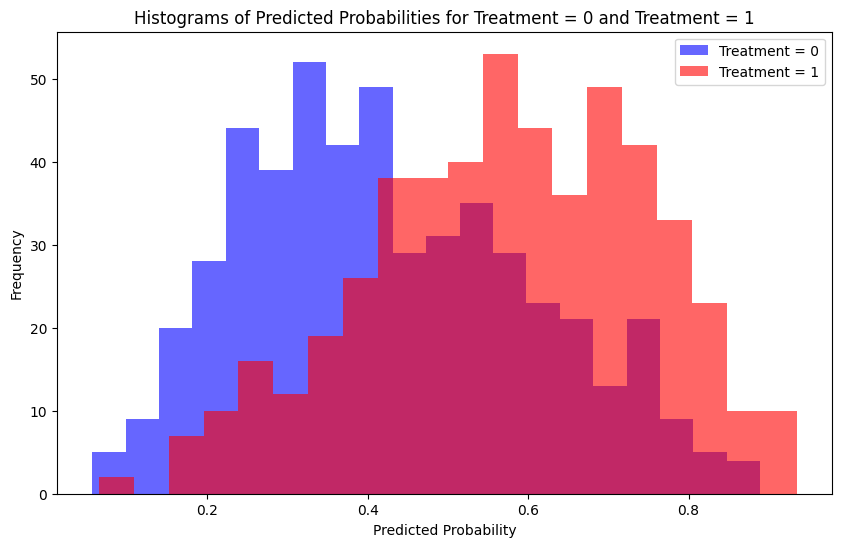

In [237]:
matched_lr_model = train_propensity_model(LogisticRegression(max_iter=1000), matched_X_train, matched_T_train)
check_overlap(matched_lr_model, matched_X_train, matched_T_train)

#### Q10. Did the balance improve after matching? Did the overlap improve after matching? Explain.

## Answer 10:
After matching, we can see that the balance for 'X17' improved, with SMD now less than 0.1. This happened because 'X17' was included in the top features we gave to the matching algorithm. If we choose ['X16', 'X17', 'X18', 'X19', 'X20'] as the features for matching, then all of them will have SMD less than 0.1, as shown below.

For overlap, there are still some areas where there are no treatment samples (around 0.1) and no control units (around 1). So, we have almost full overlap, but not completely. Matching only reduces the sample size, so if there was a probability with zero frequency before matching, it will still be zero after matching. This means the overlap does not really improve just by matching.

In [252]:
distance_features = ['X16', 'X17', 'X18', 'X19', 'X20'] 
matched_X_train, matched_T_train, matched_y_train = matching(X_train, T_train, y_train, top_features=distance_features)
table1_1 = TableOne(pd.concat([matched_X_train, matched_T_train], axis=1), columns=['X16', 'X17', 'X18', 'X19', 'X20'], groupby='T', nonnormal=[],
                  pval=False, smd=True)
print(table1_1.tabulate(tablefmt="fancy_grid"))

╒════════════════╤════╤═══════════╤════════════╤════════════╤════════════╤═════════════╕
│                │    │ Missing   │ Overall    │ 0          │ 1          │ SMD (0,1)   │
╞════════════════╪════╪═══════════╪════════════╪════════════╪════════════╪═════════════╡
│ n              │    │           │ 1016       │ 508        │ 508        │             │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X16, mean (SD) │    │ 0         │ -0.2 (1.0) │ -0.2 (1.0) │ -0.2 (1.0) │ -0.002      │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X17, mean (SD) │    │ 0         │ 1.0 (1.0)  │ 0.9 (0.9)  │ 1.0 (1.0)  │ 0.031       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X18, mean (SD) │    │ 0         │ 0.5 (0.9)  │ 0.5 (0.9)  │ 0.5 (0.9)  │ 0.018       │
├────────────────┼────┼───────────┼────────────┼────────────┼────────────┼─────────────┤
│ X19, mean (SD) │   

In [ ]:
def calculate_matching_att(T, y):
    """
    Receive propensity model and X, returns ATT inferred on X

    You must return or print the ATT estimation on X based on matching.
    :param model:
    :param X:
    :return:
    """

    treated_outcomes = y[T == 1]
    control_outcomes = y[T == 0]
    att = np.mean(treated_outcomes) - np.mean(control_outcomes)
    return att

Provide the point-estimate of the ate on the matched validation set

In [240]:
matched_X_val, matched_T_val, matched_y_val = matching(X_val, T_val, y_val)
calculate_matching_att(matched_T_val, matched_y_val)

np.float64(3.8071532149530025)

In [255]:
def matching_confidence_intervals(matching_algorithm, X_train, T_train, y_train, X_val, T_val, y_val):
    """
    Receives your matching algorithm for each intervention arm and returns 95% confidence intervals.
    You do not need to use every parameter passed to this method and you can add additional parameters.

    You must either print, visualize the confidence intervals or return them as a list.
    :param model:
    :param X_train:
    :param T_train:
    :param y_train:
    :param X_val:
    :param T_val:
    :param y_val:
    :return:
    """
    n_bootstraps = 100
    alpha = 0.05
    ates = []
    for _ in range(n_bootstraps):
        # X_train_sample, T_train_sample, y_train_sample = resample(X_train, T_train, y_train)
        X_val_sample, T_val_sample, y_val_sample = resample(X_val, T_val, y_val)
        X_val_sample = X_val_sample.reset_index(drop=True)
        T_val_sample = T_val_sample.reset_index(drop=True)
        y_val_sample = y_val_sample.reset_index(drop=True)
        # Now use positional indices throughout the matching algorithm
        matched_X_val, matched_T_val, matched_y_val = matching_algorithm(X_val_sample, T_val_sample, y_val_sample)
        ate = calculate_matching_att(matched_T_val, matched_y_val)
        ates.append(ate)
    lower = np.percentile(ates, 100 * alpha / 2)
    upper = np.percentile(ates, 100 * (1 - alpha / 2))
    return (lower, upper)

In [256]:
matching_ci = matching_confidence_intervals(matching, X_train, T_train, y_train, X_val, T_val, y_val)
print(matching_ci) # if you did not show above

(np.float64(2.7349206512447566), np.float64(5.303407518432605))


Q11. Let's imagine that each row in the data represents an employee.
T represents if the employee has undertaken a training program. And Y is the amount of money (in thousands of dollars) that each person has cost or earned the company after going through the program. Would you recommend the program?
Explain your decision by looking at the confidence intervals that you received from S-Learner, T-Learner, IPW and matching.
Note that the ATT from matching is not the same as ATE for the others.

## Answer 11:
Yes, we would recommend the program.

Looking at the results, both the S-Learner and T-Learner methods produced confidence intervals that are entirely above zero (with the S-Learner lower bound around 0.9 and the T-Learner lower bound around 1.9). This suggests a positive and statistically significant effect of the training program on the company's earnings. Additionally, the T-Learner with linear regression achieved an almost perfect fit (very low RMSE and R² close to 1), which increases our confidence in these estimates.

The IPW method is the only approach where the confidence interval includes zero, and it is also much wider than the others. This likely indicates higher variance and less precision, possibly due to extreme weights or limited overlap in propensity scores.

The matching method estimates the ATT (not ATE), but its point estimate is also positive, further supporting the benefit of the program.